# Normalized Difference Vegetation Index (NDVI) for a field

Normalized Difference Vegetation Index (NDVI) is used to quantify vegetation greenness and is useful in understanding vegetation density and assessing changes in plant health. It is calculated based on how plants reflect certain ranges of the electromagnetic spectrum. A healthy plant—one with a lot of chlorophyll and cell structures—actively absorbs red light and reflects NIR. An unhealthy plant will do the exact opposite. Satellite sensors in space measure wavelengths of light absorbed and reflected by green plants. The simple mathematical formula (below) calculates the NDVI and, in turn, transforms raw satellite data into vegetation indices which is defined as

$NDVI = \frac{(NIR - RED)}{(NIR+RED)}$

Geospatial APIs has the necessary NIR and RED Sentinel 2 A/B satellite data which has helped us derive NDVI using the above formula. 
We also provide flexibility to users to derive their own NDVI data using the available NIR and RED data as part of a UDF expression. Refer to the [tutorials](https://pairs.res.ibm.com/tutorial/legacy/api/v01x/udfs.html) for details on UDFs.

However, in this sample we'll be directly utilizing the already caliberated and stored NDVI data for a given Well-Known Text (WKT) Polygon.

Helpful references:
- https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index
- https://www.researchgate.net/figure/Reference-NDVI-values-for-different-land-areas_tbl1_263004601
- https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/normalized-difference-vegetation-index

## **[Step 1]** Generate a Well-Known Text (WKT) Polygon String for a desired location 
#### _2 Options: QGIS or [wktmap website](https://wktmap.com/)_

----------------------------------
### **Using QGIS to generate WKT Polygon String**
1. Install _Get WKT_ plugin
   - Select _Plugin_, then in drop down menu, select _Manage and Install Plugins..._
     
     ![qgis_wkt_step1.png](create_wkt_polygon_images/qgis_wkt_step1.png)

   - Within _Plugin_ pop up window,

     (1) Select _Not installed_

     (2) Type in the search bar _Get WKT_, and select _Get WKT_

     (3) Click _Install Plugin_
     
        ![qgis_wkt_step2.png](create_wkt_polygon_images/qgis_wkt_step2.png)


   - Notification will appear indicating _Plugin installed successfully_, this will automatically add _WKT_ widget in QGIS bar.
     
     ![qgis_wkt_step3.png](create_wkt_polygon_images/qgis_wkt_step3.png)


2. Now, lets create a WKT Polygon String
   
   - Open a Street Map 
     
     (1) Under _XYZ Tiles_, select _OpenStreetMap_

     (2) Generates a World View Map

        ![qgis_wkt_step4.png](create_wkt_polygon_images/qgis_wkt_step4.png)


   - Create a Scratch Layer

     (1) Click _New Temporary Scratch Layer_ widget and a pop up window will appear

     (2) Update _Geometry Type_ to be _Polygon_

     (3) Click _OK_

       ![qgis_wkt_step5.png](create_wkt_polygon_images/qgis_wkt_step5.png)


   - Next, select widget _Add Polygon Feature_

     ![qgis_wkt_step6.png](create_wkt_polygon_images/qgis_wkt_step6.png)

   - Start drawing desired polygon by _left_ clicking, on the last point _right_ click to complete the desired polygon
     
     ![qgis_wkt_step7.png](create_wkt_polygon_images/qgis_wkt_step7.png)

   
   - Next, lets select the polygon created from above
      
     (1) Select widget _Select Features by area or single click_

     (2) In drop down, select _Select Feature(s)_

     (3) Then click the created polygon

        ![qgis_wkt_step8.png](create_wkt_polygon_images/qgis_wkt_step8.png)


        Polygon color will change indicating the polygon was selected
     
        ![qgis_wkt_step9.png](create_wkt_polygon_images/qgis_wkt_step9.png)


   - Now lets use _Get WKT_ widget

     (1) Within drop down menu, select _Get WKT String_
     
        ![qgis_wkt_step10.png](create_wkt_polygon_images/qgis_wkt_step10.png)


      Pop up screen will appear with generated WKT Polygon String!
 
        ![qgis_wkt_step11.png](create_wkt_polygon_images/qgis_wkt_step11.png)
    

--------------------------------------------
### **Using [wktmap website](https://wktmap.com/) to generate WKT Polygon String**

1. Initially there will already be a polygon set, therefore press _Clear_ to generate a new polygon

   ![wktmap_step1.png](create_wkt_polygon_images/wktmap_step1.png)

2. On right hand corner, select _Draw a Polygon_ widget
   
   ![wktmap_step2.png](create_wkt_polygon_images/wktmap_step2.png)

3. Find the area of interest and start plotting down points. Connect the last point to the initial point to complete the polygon
   
   ![wktmap_step3.png](create_wkt_polygon_images/wktmap_step3.png)

4. WKT Polygon has now been generated!
   
   ![wktmap_step4.png](create_wkt_polygon_images/wktmap_step4.png)


----------------------------------
## **[Step 2]** NDVI Calculation for a field using API

Let's use the WKT Polygon generated from above to fetch NDVI values from Geospatial APIs layer 49464, from High resolution imagery (ESA Sentinel 2) dataset. Layer ID used here, 49464, can be found using the catalogue sub-module (refer [here](../../../../v4_apis/samples/quickstart/agb_catalogue/agb_catalogue.ipynb) for help).

In this use case, we will use IBM Hursley Park location for the day January 1st, 2023. 

Let's go ahead, define and submit a WKT Polygon query.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from IPython.display import display as display_summary

import ibmpairs.client as client
import ibmpairs.query as query

In [2]:
EI_API_KEY=os.environ.get('EI_API_KEY')
EI_TENANT_ID=os.environ.get('EI_TENANT_ID')
EI_ORG_ID=os.environ.get('EI_ORG_ID')

ei_client = client.get_client(api_key       = EI_API_KEY,
                              tenant_id     = EI_TENANT_ID,
                              org_id        = EI_ORG_ID
                             )

query_json = {
  "name": "IBM Hursley Park",
  "spatial": {
    "type": "poly",
    "polygon": {
      "wkt": "POLYGON ((-1.402946 51.024756, -1.402913 51.025498, -1.402849 51.025822, -1.401497 51.026679, -1.401068 51.026935, -1.400789 51.026989, -1.400843 51.027077, -1.400778 51.027468, -1.400145 51.027475, -1.399502 51.02763, -1.39742 51.02757, -1.397291 51.027759, -1.398214 51.028325, -1.398289 51.028521, -1.398096 51.028899, -1.396176 51.028508, -1.396444 51.030599, -1.396251 51.031409, -1.396337 51.031571, -1.395156 51.031625, -1.394384 51.031139, -1.394212 51.031004, -1.393847 51.031004, -1.393912 51.030532, -1.394277 51.030761, -1.394534 51.030667, -1.394942 51.028157, -1.394556 51.027617, -1.394727 51.027495, -1.39462 51.027246, -1.394234 51.027185, -1.393472 51.026429, -1.393332 51.026126, -1.393504 51.025869, -1.393064 51.025606, -1.392775 51.025471, -1.392817 51.025012, -1.392817 51.02315, -1.39271 51.022448, -1.392667 51.021408, -1.392903 51.021098, -1.393847 51.020895, -1.395864 51.02103, -1.396036 51.021233, -1.395564 51.022178, -1.396401 51.022218, -1.397924 51.022097, -1.399126 51.022164, -1.400306 51.02261, -1.401165 51.023069, -1.402516 51.023797, -1.402817 51.024256, -1.402967 51.024607, -1.402946 51.024756))"
    }
  },
  "temporal": {
    "intervals": [
      {
        "start": "2023-01-01 00:00:00",
        "end": "2023-01-01 00:00:00"
      }
    ]
  },
  "layers": [
    {
      "type": "raster",
      "id": "49464"
    }
  ]
}

NDVI_WKT_Result = query.submit_check_status_and_download(query_json)


2024-08-01 12:27:42 - paw - INFO - The client authentication method is assumed to be OAuth2.
2024-08-01 12:27:42 - paw - INFO - Legacy Environment is False
2024-08-01 12:27:42 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2024-08-01 12:27:54 - paw - INFO - Authentication success.
2024-08-01 12:27:54 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3
2024-08-01 12:27:54 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2024-08-01 12:27:55 - paw - INFO - The query was successfully submitted with the id: 1722513600_19675103.
2024-08-01 12:27:55 - paw - INFO - The query 1722513600_19675103 has the status Queued.
2024-08-01 12:28:25 - paw - INFO - The query 1722513600_19675103 has the status Succeeded.
2024-08-01 12:28:25 - paw - INFO - The query 1722513600_19675103 was successful after checking the status.
2024-08-01 12:28:56 - paw - INFO - The query 1722513600_19675103 has the status Succ

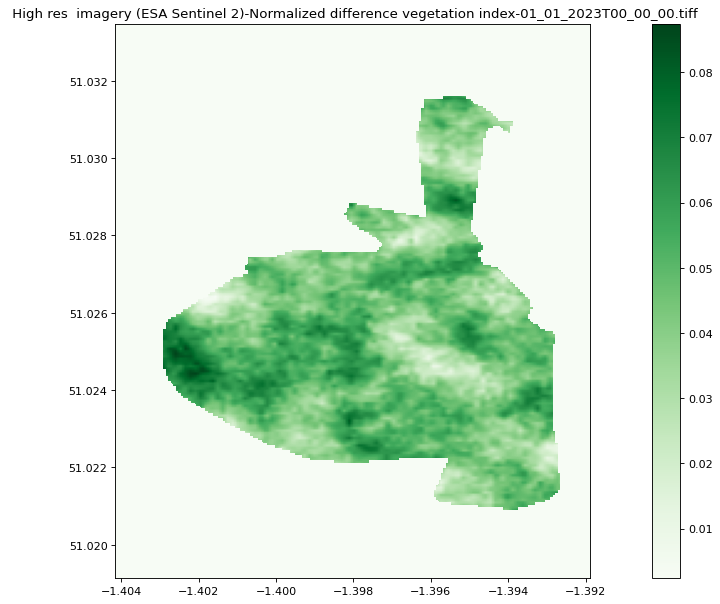

In [3]:
# Function to display the resulting Tiff(s).
ndvi_result = NDVI_WKT_Result.list_files()
for file in ndvi_result:
    if file.endswith('.tiff'):
        with open(file+'.json', 'r') as metadata_file:
            metadata = json.load(metadata_file)
        bbox=metadata["boundingBox"]
        extent=[bbox["minLongitude"],
                bbox["maxLongitude"],
                bbox["minLatitude"],
                bbox["maxLatitude" ]]  
        array_tiff = np.array(PIL.Image.open(file))
        plt.figure(figsize = (20, 9), dpi=80)
        vmin = metadata["rasterStatistics"]["pixelMin"]
        vmax = metadata["rasterStatistics"]["pixelMax"]
        plt.imshow(array_tiff,
                   cmap = 'Greens', 
                   vmin=vmin, 
                   vmax=vmax,
                   extent = extent)
        plt.colorbar()
        plt.title(" " + os.path.basename(file))

In [4]:
# Function to display the resulting summary file(s).
for file in ndvi_result:
    if file.endswith('.json'):  #  show the result statistics
        summary=pd.read_json(file)
        summary['rasterStatistics'] = pd.to_numeric(summary['rasterStatistics'])
        pd.set_option('display.float_format', '{:.6f}'.format)
        display_summary(summary)

,pixelType,pixelNoDataVal,spatialRef,boundingBox,pixelDimensions,rasterStatistics
minLatitude,fl,-9999,EPSG:4326,51.019136,NaN,NaN
maxLatitude,fl,-9999,EPSG:4326,51.033472,NaN,NaN
minLongitude,fl,-9999,EPSG:4326,-1.404160,NaN,NaN
maxLongitude,fl,-9999,EPSG:4326,-1.391872,NaN,NaN
pixelSizeDegreeLongitude,fl,-9999,EPSG:4326,NaN,0.000064,NaN
pixelSizeDegreeLatitude,fl,-9999,EPSG:4326,NaN,0.000064,NaN
numberPixelsLatitude,fl,-9999,EPSG:4326,NaN,224.000000,NaN
numberPixelsLongitude,fl,-9999,EPSG:4326,NaN,192.000000,NaN
pixelMin,fl,-9999,EPSG:4326,NaN,NaN,0.002400
pixelMax,fl,-9999,EPSG:4326,NaN,NaN,0.087400
